# Benchmarking the MPS code

Here we benchmark our MPS reuslts (TEBD and TDVP) with respect to our existing exact diagonalaization data

In [40]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy.interpolate import UnivariateSpline

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import h5py
import json
import matplotlib 
from mpl_toolkits.axes_grid1 import make_axes_locatable

import os
import sys  

from ast import literal_eval

from qutip import  *

sys.path.append('../../scripts') 

from qutip_tools import *


In [53]:
# define basic figure sizes
bwidth=7
bheight=5
base_font = 21

matplotlib.rcParams.update({'font.size': base_font,"legend.fontsize":base_font-4 ,"font.family": "serif", 
                            "font.serif": "CMU Serif, Times New Roman",
                           'text.usetex' : True })

sns.set_palette("colorblind")

fig_route = "../../plots/benchmark_mps/"

data_route = "../../data/exact_diag_new/L=60/"
MPS_route= "../../data/MPS/L=60/"

# Functions

In [54]:
def interpolate_short_array(b,a):
    # In order to compare arrays b and a of different length we
    # this makes sense only if a and b start and end at the "same place" but are
    # sampled at different rates
    interpol_array = 0
    
    return  np.interp(np.linspace(0, len(b) - 1, len(a)), np.arange(len(b)),b)

def get_bloch_angles(ρ_list):
    # calculates the bloch angles from the qubit-reduced density matrix
    # keep in mind that the arccos and arcsin loop the angle around
    # ρ_list: list containing the time evolutions of the qubit density matrix

    cosθ_list = []
    sinϕtlist = []
    θt_list = []
    ϕtlist = []
    for i in range(0, len(ρ_list)):
        ρt = TEBD_qubit_rho[i]
        cosθt = 2*ρt[0,0] - 1
        θt = np.arccos(cosθt)
        sinϕt = (ρt[1,0] - ρt[0,1])/(1j*np.sin(θt))
        ϕt = np.arcsin(sinϕt)
        
        cosθ_list.append(np.real(cosθt))
        sinϕtlist.append(np.real(sinϕt))
        θt_list.append(np.real(θt))
        ϕtlist.append(np.real(ϕt))
        
    return θt_list, ϕtlist    

def get_FWHM(xvals, Func, time_index):
    # gets the full width at half maximum of Func(xvals) at time_index
    spline = UnivariateSpline(xvals, Func - np.max(Func) / 2, s=0)
    bond_root = spline.roots() 
    # the first two roots yield the width at half maximum
    FWHM = bond_root[1] - bond_root[0]
    return FWHM
    

# Inital Condition Testing

In [55]:

file_list = get_file_names_on(["TEBD2","om{}_".format(0.3), "Del{}_".format(6.0),"t{}".format(0.05)], MPS_route)
print(file_list)
TEBD_params, TEBD_times, TEBD_occ, TEBD_bond_dim, TEBD_entropies, TEBD_qubit_rho  = load_MPS(MPS_route, 
                                                                                             file_list[0]) 

TEBD_params

['TEBD2_L60_J1.0_t0.05_om0.3_Del6.0_xo11_k1.257_bindex30_maxtau31.543866727148018_tstep0.07_cutoff-18_fixed_theta0.9425_phi0.0.h5', 'TEBD2_L60_J1.0_t0.05_om0.3_Del6.0_xo11_k1.571_bindex30_maxtau30.0_tstep0.07_cutoff-18_fixed_theta0.9425_phi0.0.h5', 'TEBD2_L60_J1.0_t0.05_om0.3_Del6.0_xo11_k0.4712_bindex30_maxtau66.08067793755801_tstep0.07_cutoff-18_fixed_theta0.9425_phi0.0.h5', 'TEBD2_L60_J1.0_t0.05_om0.3_Del6.0_xo11_k1.1_bindex30_maxtau33.66978712903083_tstep0.07_cutoff-18_fixed_theta0.9425_phi0.0.h5', 'TEBD2_L60_J1.0_t0.05_om0.3_Del6.0_xo11_k1.414_bindex30_maxtau30.373953773640086_tstep0.07_cutoff-18_fixed_theta0.9425_phi0.0.h5', 'TEBD2_L60_J1.0_t0.05_om0.3_Del6.0_xo11_k0.7854_bindex30_maxtau42.42640687119285_tstep0.07_cutoff-18_fixed_theta0.9425_phi0.0.h5', 'TEBD2_L60_J1.0_t0.05_om0.3_Del6.0_xo11_k0.6283_bindex30_maxtau51.039048501122394_tstep0.07_cutoff-18_fixed_theta0.9425_phi0.0.h5', 'TEBD2_L60_J1.0_t0.05_om0.3_Del6.0_xo11_k0.9425_bindex30_maxtau37.08203932499369_tstep0.07_cutoff-

{'Omega': 0.3,
 'x0': 11,
 'computation_time': 84.893114541,
 'L': 60,
 'cutoff': 1e-18,
 't': 0.05,
 'bond_index': 30,
 'max_time': 31.543866727148018,
 'k0': 1.2566370614359172,
 'qinit': 'fixed',
 'spread': 6.0,
 'qubit_theta': 0.9424777960769379,
 'J': 1.0,
 'evol_type': 'TEBD2',
 'time_step': 0.07,
 'type': 'TEBD2',
 'qubit_phi': 0}

Text(0.5, 0, 'Time')

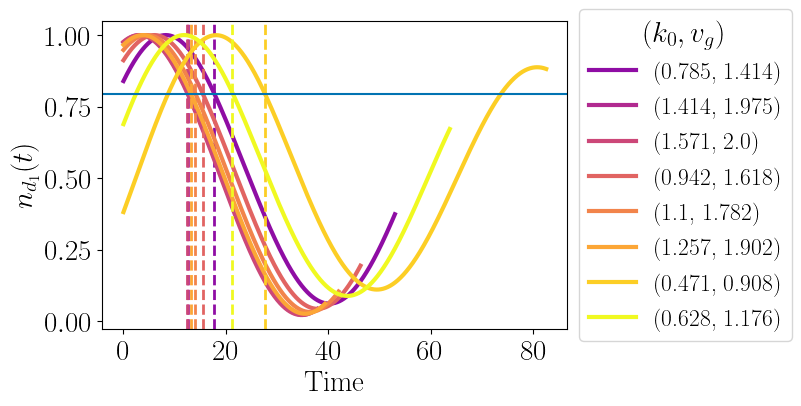

In [44]:
colors = plt.cm.plasma(np.linspace(0.3,1,len(file_list)))

fig, ax = plt.subplots(figsize=(6,4))

for i in range(0,len(file_list)):
    file_name = file_list[i]
    TEBD_params, TEBD_times, TEBD_occ, TEBD_bond_dim, TEBD_entropies, TEBD_qubit_rho  = load_MPS(MPS_route, 
                                                                                             file_list[i]) 
    # calculate the time it takes it to hit the bond (scattering approx)
    vg = 2*np.sin(TEBD_params["k0"])
    tau_to_bond = (TEBD_params["bond_index"]-TEBD_params["x0"])/vg
    
    lab = "("+str(round(TEBD_params["k0"],3)) + ", " + str(round(vg,3))+")" 
    
    plt.plot(TEBD_times, TEBD_occ[:,-2], linewidth=3, label=lab , c=colors[i])
    
    plt.axvline(tau_to_bond, linestyle="dashed",c=colors[i], linewidth=2)    
    
plt.axhline(np.cos(TEBD_params["qubit_theta"]/2)**2)
    
plt.legend(title=r"$(k_0, v_g)$",loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel(r"$n_{d_1}(t)$")
plt.xlabel(r"Time")

# TDVP vs TEBD

In [45]:
0.9*np.pi/2

1.413716694115407

In [46]:
large_MPS_route = "../../data/MPS/L=100/"
TEBD_file_list =  get_file_names_on(["TEBD", "k1.414", "t0.01"], large_MPS_route)
TDVP_file_list =  get_file_names_on(["TDVP", "k1.414", "t0.01"], large_MPS_route)

print(TEBD_file_list)
print(TDVP_file_list)

TEBD_params, TEBD_times, TEBD_occ, TEBD_bond_dim, TEBD_entropies, TEBD_qubit_rho  = load_MPS(large_MPS_route, 
                                                                                             TEBD_file_list[0]) 
TDVP_params, TDVP_times, TDVP_occ, TDVP_bond_dim, TDVP_entropies, TDVP_qubit_rho  = load_MPS(large_MPS_route, 
                                                                                             TDVP_file_list[0]) 

['TEBD2_L100_J1.0_t0.01_om0.3_Del6.0_xo25_k1.414_bindex50_maxtau50.623256289400146_tstep0.07_cutoff-18_fixed_theta0.9425_phi0.0.h5']
['TDVP_L100_J1.0_t0.01_om0.3_Del6.0_xo25_k1.414_bindex50_maxtau50.623256289400146_tstep0.07_cutoff-18_fixed_theta0.9425_phi0.0.h5']


In [47]:
TEBD_bindex = TEBD_params["bond_index"] # because of Julia indexing
TEBD_R = np.sum(TEBD_occ[:,:TEBD_bindex-1],axis=1)
TEBD_T = np.sum(TEBD_occ[:,TEBD_bindex+1:-2],axis=1)
TEBD_Bond = np.sum(TEBD_occ[:,TEBD_bindex-1:TEBD_bindex+1],axis=1)

TDVP_R = np.sum(TDVP_occ[:,:TEBD_bindex-1],axis=1)
TDVP_T = np.sum(TDVP_occ[:,TEBD_bindex+1:-2],axis=1)
TDVP_Bond = np.sum(TDVP_occ[:,TEBD_bindex-1:TEBD_bindex+1],axis=1)


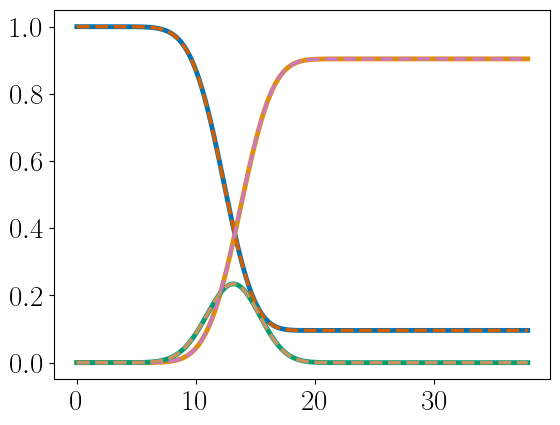

In [48]:
plt.plot(TEBD_times, TEBD_R, linewidth=3.5, label="Reflection")
plt.plot(TEBD_times, TEBD_T, linewidth=3.5, label="Transmission")
plt.plot(TEBD_times, TEBD_Bond, linewidth=3.5, label="Bond")

plt.plot(TDVP_times, TDVP_R, linewidth=2.5, label="Reflection",linestyle="dashed")
plt.plot(TDVP_times, TDVP_T, linewidth=2.5, label="Transmission",linestyle="dashed")
plt.plot(TDVP_times, TDVP_Bond, linewidth=2.5, label="Bond",linestyle="dashed")

Text(0, 0.5, '$S_{VN}$')

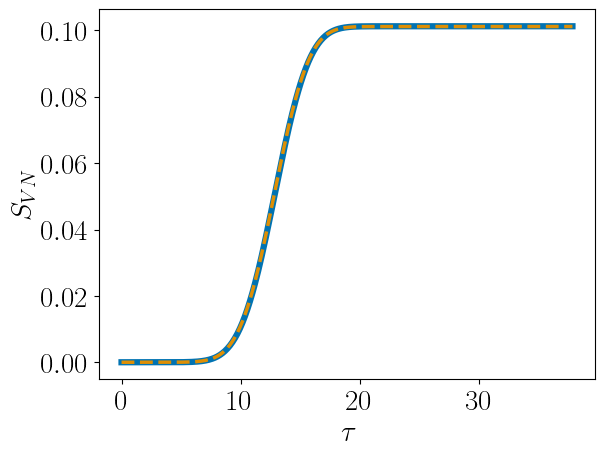

In [49]:
plt.plot(TEBD_times,TEBD_entropies, linewidth=4.5)
plt.plot(TDVP_times,TDVP_entropies,linewidth=2.5, linestyle="dashed")
plt.xlabel(r"$\tau$")
plt.ylabel(r"$S_{VN}$")

In [50]:
# load all exact diag data
exact_df = pd.read_csv("../../data/exp_pro/exact_diag_L=60.csv")

# Error Summary

Compare the maximum errors systemathically for different parameters

In [51]:
MPS_file_list = get_file_names_on([""], MPS_route) # get all filenames for mps
# load some file to get the parameters since all are the same
MPS_params, _, _, _, _, _  = load_MPS(MPS_route, MPS_file_list[0])


In [24]:
data_dict = {k: [] for k in MPS_params.keys()}
data_dict["max_rabi_err2"] = []
data_dict["max_Transmision_err2"] = []
data_dict["max_Reflection_err2"] = []
data_dict["max_Entropy_abserr"] = []
data_dict["max_Entropy"] = []
data_dict["final_bond_dim"] = []


for i in range(0,len(MPS_file_list)):
    MPS_file = MPS_file_list[i]
    MPS_params, MPS_times, MPS_occ, MPS_bond_dim, MPS_entropies, MPS_qubit_rho  = load_MPS(MPS_route, MPS_file)  
    # load exact result for benchmark
    exact_list = get_file_names_on(["bw6.0","om0.3_".format(MPS_params["Omega"]),"fixed", 
                                    "k{}", "t0.1".format(MPS_params["t"])], data_route)
    # look for missing data in exact
    if len(exact_list)==0:
        print("missing for exact diag:")
        print(MPS_file)
        continue
        
    # load exact
    param_dict, times, n_bond, n_left, n_right, n_d1, n_d2, traject, VN_entropy, purity, dd_theta , dd_phi = load_data(data_route,exact_list[0])
    
    # error in rabi (if one is good then both are)
    MPS_d1 = MPS_occ[:,-2]
    # interpolate to compare the same amount of datapoints
    d1_interpol = interpolate_short_array(MPS_d1,n_d1)
    Err2 = (d1_interpol- n_d1)**2
    rabi_error = np.max(Err2)
    
    # error in transmision and reflection
    MPS_bindex = MPS_params["bond_index"] # because of Julia indexing
    MPS_R = np.sum(MPS_occ[:,:MPS_bindex-1],axis=1)
    MPS_T = np.sum(MPS_occ[:,MPS_bindex+1:-2],axis=1)
    
    MPS_R_interpol = interpolate_short_array(MPS_R,n_left)
    Err2_R = (MPS_R_interpol - n_left)**2
    MPS_T_interpol = interpolate_short_array(MPS_T,n_right)
    Err2_T = (MPS_T_interpol - n_right)**2

    R_error = np.max(Err2_R)
    T_error = np.max(Err2_T)

    # error in entropy
    S_rel_err = np.abs(max(VN_entropy) - max(MPS_entropies))/max(VN_entropy)

    # now assign the parameters to the data dict
    
    for key in MPS_params.keys():
        data_dict[key].append(MPS_params[key])
    
    data_dict["max_rabi_err2"].append(rabi_error)
    data_dict["max_Reflection_err2"].append(R_error)
    data_dict["max_Transmision_err2"].append(T_error)
    data_dict["max_Entropy_abserr"].append(S_rel_err)
    data_dict["max_Entropy"].append(max(MPS_entropies))

    data_dict["final_bond_dim"].append(MPS_bond_dim[-1])

error_df = pd.DataFrame.from_dict(data_dict)


missing for exact diag:
TEBD2_L100_J1.0_t0.8_om0.3_Del6.0_xo25_k0.7854_bindex50_maxtau70.71067811865476_tstep0.07_cutoff-18_fixed_theta0.9425_phi0.0.h5
missing for exact diag:
TEBD2_L100_J1.0_t0.3_om0.3_Del6.0_xo25_k1.571_bindex50_maxtau50.0_tstep0.07_cutoff-18_fixed_theta0.9425_phi0.0.h5
missing for exact diag:
TEBD2_L100_J1.0_t0.001_om0.3_Del6.0_xo25_k1.571_bindex50_maxtau50.0_tstep0.07_cutoff-18_fixed_theta0.9425_phi0.0.h5
missing for exact diag:
TEBD2_L100_J1.0_t2.0_om0.3_Del6.0_xo25_k0.4712_bindex50_maxtau110.13446322926335_tstep0.07_cutoff-18_fixed_theta0.9425_phi0.0.h5
missing for exact diag:
TEBD2_L100_J1.0_t0.07_om0.3_Del6.0_xo25_k0.6283_bindex50_maxtau85.06508083520399_tstep0.07_cutoff-18_fixed_theta0.9425_phi0.0.h5
missing for exact diag:
TEBD2_L100_J1.0_t0.3_om0.3_Del6.0_xo25_k0.9425_bindex50_maxtau61.80339887498948_tstep0.07_cutoff-18_fixed_theta0.9425_phi0.0.h5
missing for exact diag:
TEBD2_L100_J1.0_t0.5_om0.3_Del6.0_xo25_k1.257_bindex50_maxtau52.573111211913364_tstep0.0

In [25]:
error_df

,Omega,x0,computation_time,L,cutoff,t,bond_index,max_time,k0,qinit,...,evol_type,time_step,type,qubit_phi,max_rabi_err2,max_Transmision_err2,max_Reflection_err2,max_Entropy_abserr,max_Entropy,final_bond_dim


Index(['Omega', 'x0', 'computation_time', 'L', 'cutoff', 't', 'bond_index',
       'max_time', 'k0', 'qinit', 'spread', 'qubit_theta', 'J', 'evol_type',
       'time_step', 'type', 'qubit_phi', 'max_rabi_err2',
       'max_Transmision_err2', 'max_Reflection_err2', 'max_Entropy_abserr',
       'max_Entropy', 'final_bond_dim'],
      dtype='object')


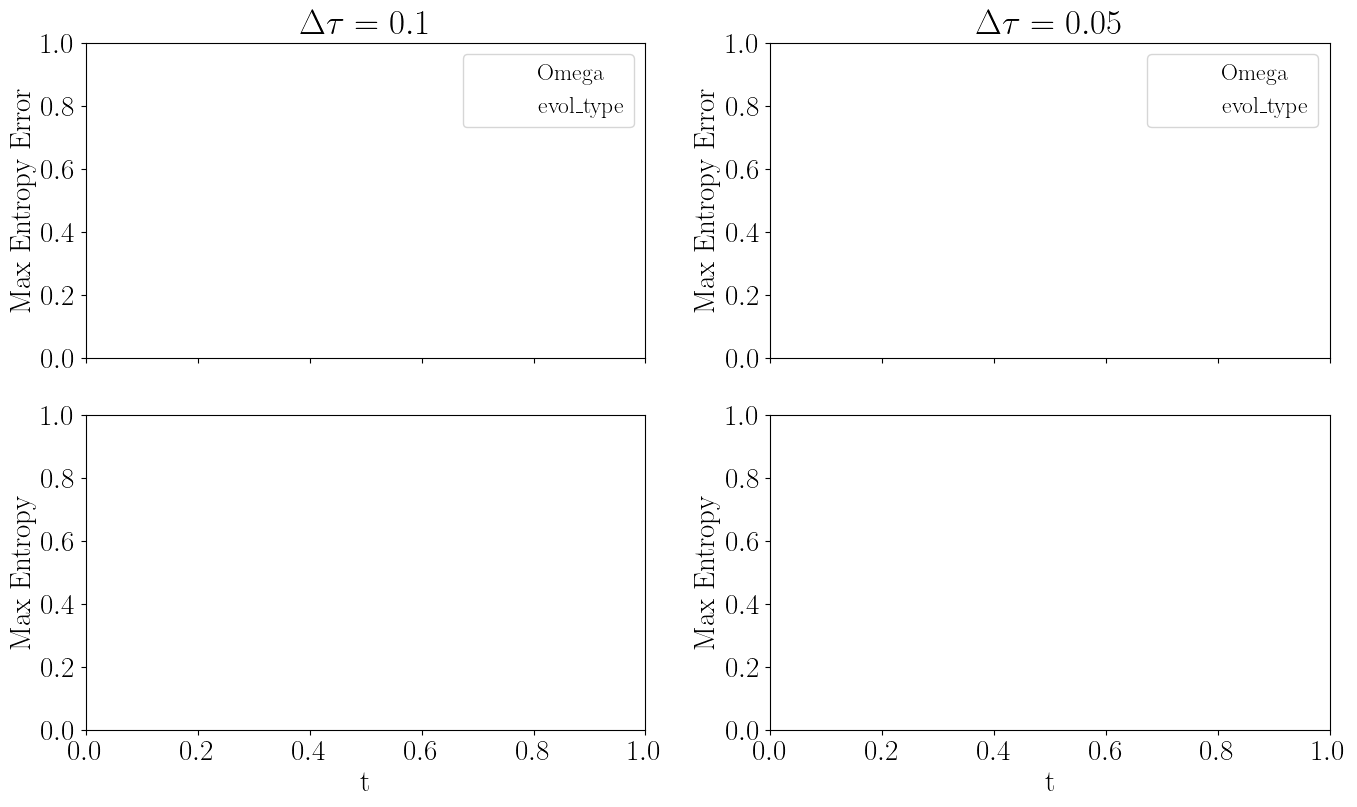

In [26]:
print(error_df.columns)

fig, ax = plt.subplots(2,2, figsize=(2*bwidth,1.7*bheight), sharex=True)

cond_ = (error_df["time_step"]==0.1) & (error_df["Omega"]!=0.0) 
sns.lineplot(data=error_df[cond_], x="t", y="max_Entropy_abserr", hue="Omega", style="evol_type",ax=ax[0,0],
             markers=True,legend=True, markeredgecolor="black")

sns.lineplot(data=error_df[cond_], x="t", y="max_Entropy", hue="Omega", style="evol_type",ax=ax[1,0],
             markers=True,legend=False,markeredgecolor="black")

cond_ = (error_df["time_step"]==0.05) & (error_df["Omega"]!=0.0) 
sns.lineplot(data=error_df[cond_], x="t", y="max_Entropy_abserr", hue="Omega", style="evol_type",ax=ax[0,1],
             markers=True,legend=True, markeredgecolor="black")

sns.lineplot(data=error_df[cond_], x="t", y="max_Entropy", hue="Omega", style="evol_type",ax=ax[1,1],
             markers=True,legend=False,markeredgecolor="black")

# sns.move_legend(ax[0,1], "upper left", bbox_to_anchor=(1, 1))
ax[0,0].set_title(r"$\Delta \tau=0.1$")
ax[0,1].set_title(r"$\Delta \tau=0.05$")
ax[0,0].set_ylabel(r"Max Entropy Error")
ax[0,1].set_ylabel(r"Max Entropy Error")

ax[1,0].set_ylabel(r"Max Entropy")
ax[1,1].set_ylabel(r"Max Entropy")
    
plt.tight_layout() 

#plt.savefig(fig_route+"Entropy_error_L=21.pdf")

ValueError: Axes(0.547727,0.11;0.352273x0.77) has no legend attached.

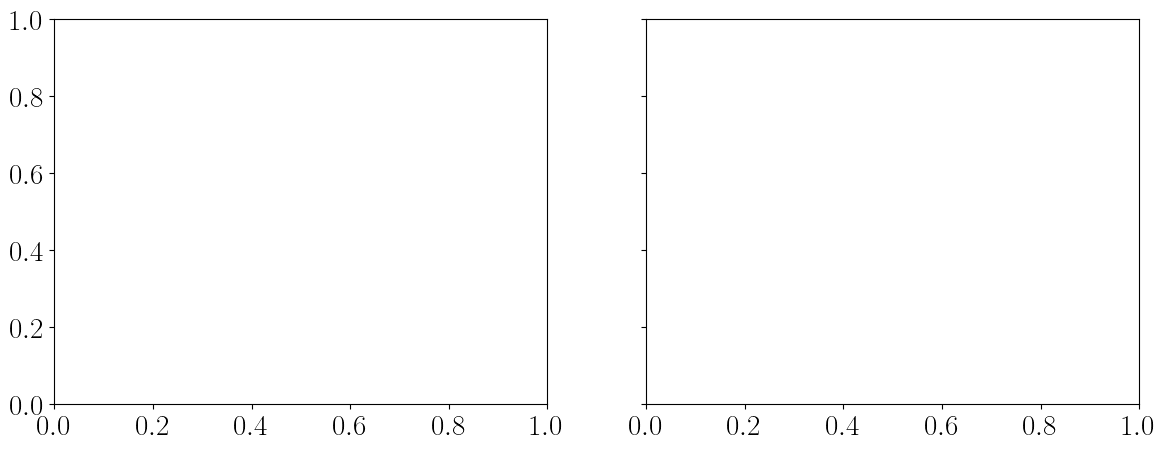

In [27]:
fig, ax = plt.subplots(1,2, figsize=(2*bwidth,bheight), sharey=True)

cond_ = (error_df["time_step"]==0.1) & (error_df["Omega"]!=0.0) 
sns.scatterplot(data=error_df[cond_], x="t", y="max_rabi_err2", hue="Omega", s=60,
               edgecolor="black", style="evol_type",ax=ax[0], legend=False)

cond_ = (error_df["time_step"]==0.025) & (error_df["Omega"]!=0.0) 
sns.scatterplot(data=error_df[cond_], x="t", y="max_rabi_err2", hue="Omega", s=60,
               edgecolor="black", style="evol_type",ax=ax[1])

sns.move_legend(ax[1], "upper left", bbox_to_anchor=(1, 1))
ax[0].set_title(r"$\Delta \tau=0.1$")
ax[1].set_title(r"$\Delta \tau=0.025$")
plt.tight_layout()

ValueError: Axes(0.547727,0.11;0.352273x0.77) has no legend attached.

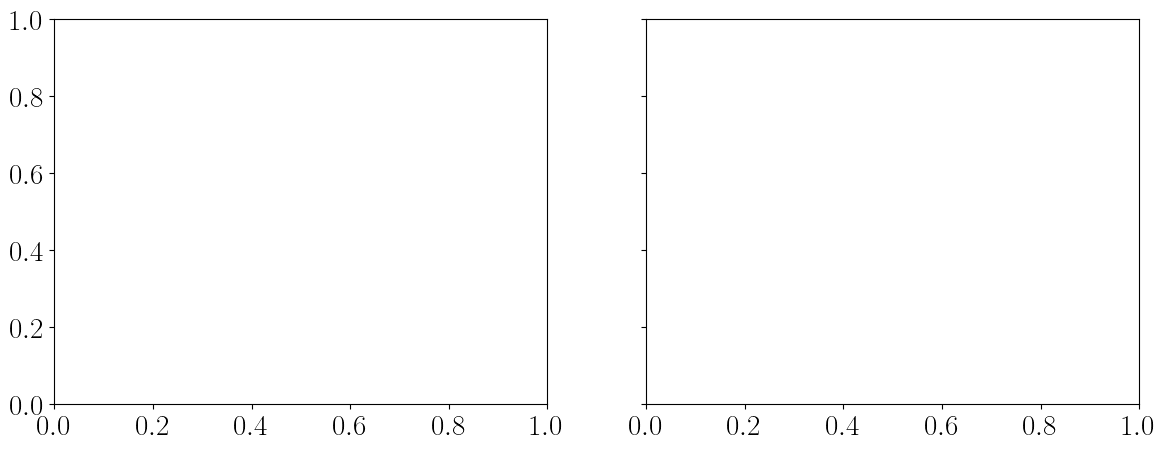

In [28]:
fig, ax = plt.subplots(1,2, figsize=(2*bwidth,bheight), sharey=True)

cond_ = (error_df["time_step"]==0.1) & (error_df["Omega"]!=0.0) 
sns.scatterplot(data=error_df[cond_], x="t", y="max_Transmision_err2", hue="Omega", s=60,
               edgecolor="black", style="evol_type",ax=ax[0], legend=False)

cond_ = (error_df["time_step"]==0.05) & (error_df["Omega"]!=0.0) 
sns.scatterplot(data=error_df[cond_], x="t", y="max_Transmision_err2", hue="Omega", s=60,
               edgecolor="black", style="evol_type",ax=ax[1])

sns.move_legend(ax[1], "upper left", bbox_to_anchor=(1, 1))
ax[0].set_title(r"$\Delta \tau=0.1$")
ax[1].set_title(r"$\Delta \tau=0.025$")
ax[0].set_ylabel(r"Max Transmission Error")

plt.tight_layout()
# plt.savefig(fig_route+"transmission_error_L=21.pdf")

ValueError: Axes(0.547727,0.11;0.352273x0.77) has no legend attached.

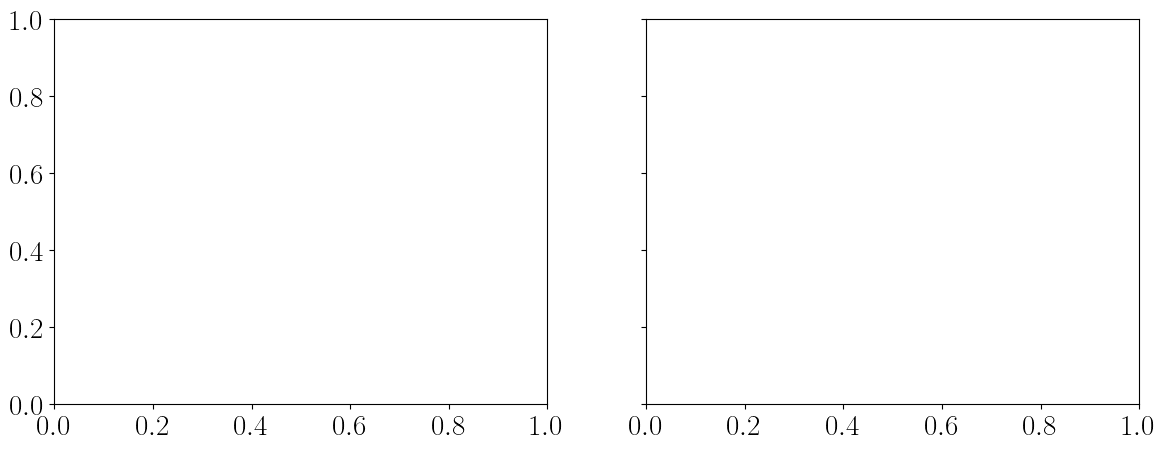

In [29]:
fig, ax = plt.subplots(1,2, figsize=(2*bwidth,bheight), sharey=True)

cond_ = (error_df["time_step"]==0.1) & (error_df["Omega"]!=0.0) 
sns.scatterplot(data=error_df[cond_], x="t", y="final_bond_dim", hue="Omega", s=60,
               edgecolor="black", style="evol_type",ax=ax[0], legend=False)

cond_ = (error_df["time_step"]==0.025) & (error_df["Omega"]!=0.0) 
sns.scatterplot(data=error_df[cond_], x="t", y="final_bond_dim", hue="Omega", s=60,
               edgecolor="black", style="evol_type",ax=ax[1])

sns.move_legend(ax[1], "upper left", bbox_to_anchor=(1, 1))
ax[0].set_title(r"$\Delta \tau=0.1$")
ax[1].set_title(r"$\Delta \tau=0.025$")
plt.tight_layout()


# Computation time and system size

In [20]:
TEBD_file_list = get_file_names_on(["TEBD"], "../../data/MPS/L_sweep/") # get all filenames for mps
TDVP_file_list = get_file_names_on(["TDVP"], "../../data/MPS/L_sweep/") 

TEBD_file_list, TDVP_file_list

(['TEBD2_L150_J1.0_t0.05_om0.1_Del2.0_k1.571_bindex75_maxtau75.0_tstep0.1_cutoff-20_free_theta3.142_phi-1.571.h5',
  'TEBD2_L300_J1.0_t0.05_om0.1_Del2.0_k1.571_bindex150_maxtau150.0_tstep0.1_cutoff-20_free_theta3.142_phi-1.571.h5',
  'TEBD2_L30_J1.0_t0.05_om0.1_Del2.0_k1.571_bindex15_maxtau15.0_tstep0.1_cutoff-20_free_theta3.142_phi-1.571.h5',
  'TEBD2_L100_J1.0_t0.05_om0.1_Del2.0_k1.571_bindex50_maxtau50.0_tstep0.1_cutoff-20_free_theta3.142_phi-1.571.h5',
  'TEBD2_L200_J1.0_t0.05_om0.1_Del2.0_k1.571_bindex100_maxtau100.0_tstep0.1_cutoff-20_free_theta3.142_phi-1.571.h5',
  'TEBD2_L50_J1.0_t0.05_om0.1_Del2.0_k1.571_bindex25_maxtau25.0_tstep0.1_cutoff-20_free_theta3.142_phi-1.571.h5',
  'TEBD2_L20_J1.0_t0.05_om0.1_Del2.0_k1.571_bindex10_maxtau10.0_tstep0.1_cutoff-20_free_theta3.142_phi-1.571.h5'],
 ['TDVP_L200_J1.0_t0.05_om0.1_Del2.0_k1.571_bindex100_maxtau100.0_tstep0.1_cutoff-20_free_theta3.142_phi-1.571.h5',
  'TDVP_L150_J1.0_t0.05_om0.1_Del2.0_k1.571_bindex75_maxtau75.0_tstep0.1_cuto

In [21]:
TEBD_comp_time_list = []
TEBD_size_list = []

TDVP_comp_time_list = []
TDVP_size_list = []
maxtime_list = [] # this is the same for both methods

# load tebd data
for MPS_file in TEBD_file_list:
    MPS_params, _, _, MPS_bond_dim, _, _  = load_MPS("../../data/MPS/L_sweep/", MPS_file) 
    TEBD_comp_time_list.append(MPS_params["computation_time"])
    TEBD_size_list.append(MPS_params["L"])
    maxtime_list.append(MPS_params["max_time"])

TEBD_comp_time_list = np.asarray(TEBD_comp_time_list)
TEBD_size_list = np.asarray(TEBD_size_list)
maxtime_list = np.asarray(maxtime_list)

# sort by system size and remove the compilation datapoint
sorted_index = np.argsort(TEBD_size_list)
TEBD_comp_time_list = TEBD_comp_time_list[sorted_index][1:]
TEBD_size_list = TEBD_size_list[sorted_index][1:]
maxtime_list = maxtime_list[sorted_index][1:]

# load tdvp data
for MPS_file in TDVP_file_list:
    MPS_params, _, _, MPS_bond_dim, _, _  = load_MPS("../../data/MPS/L_sweep/", MPS_file) 
    TDVP_comp_time_list.append(MPS_params["computation_time"])
    TDVP_size_list.append(MPS_params["L"])

TDVP_comp_time_list = np.asarray(TDVP_comp_time_list)
TDVP_size_list = np.asarray(TDVP_size_list)

# sort by system size and remove the compilation datapoint
sorted_index = np.argsort(TDVP_size_list)
TDVP_comp_time_list = TDVP_comp_time_list[sorted_index][1:]
TDVP_size_list = TDVP_size_list[sorted_index][1:]


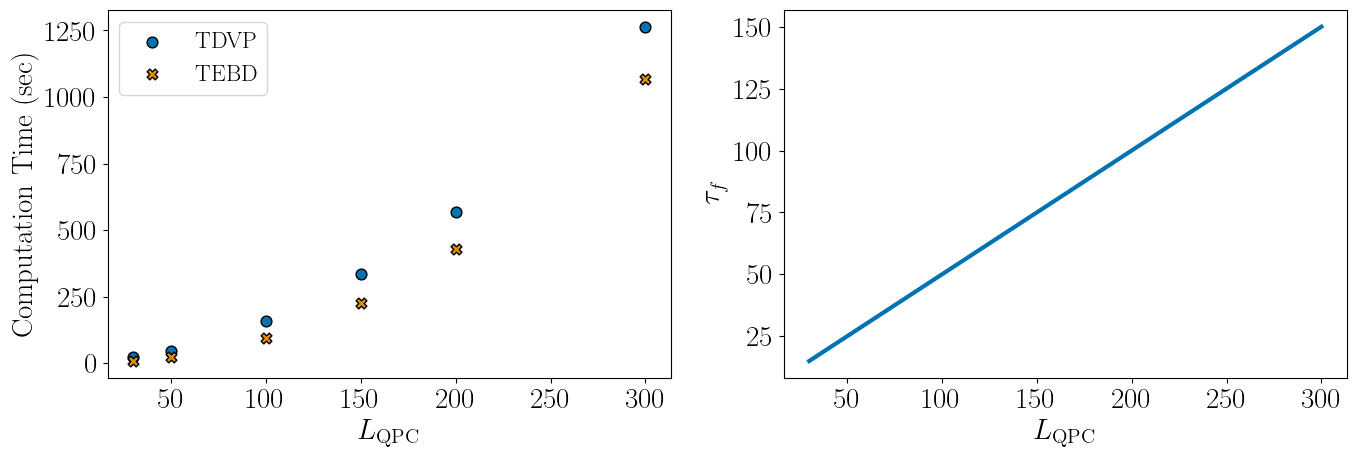

In [22]:
fig, ax = plt.subplots(1,2, figsize=(2*bwidth,bheight))

ax[0].scatter(TDVP_size_list, TDVP_comp_time_list, s=60, edgecolor="black", label="TDVP")
ax[0].scatter(TEBD_size_list, TEBD_comp_time_list, s=60, edgecolor="black" , label= "TEBD",marker="X")

ax[0].set_xlabel(r"$L_{\rm{QPC}}$")
ax[0].set_ylabel(r"Computation Time (sec)")
ax[0].legend()

ax[1].plot(TEBD_size_list, maxtime_list, linewidth=3)
ax[1].set_xlabel(r"$L_{\rm{QPC}}$")
ax[1].set_ylabel(r"$\tau_f$")

plt.tight_layout()

# plt.savefig(fig_route+"computation_time_vs_size.pdf")

# Look at single cases against exact diag

In [56]:
file_list = get_file_names_on(["TEBD2","L{}_".format(L_),"om{}_".format(Om_),
                              "bindex{}_".format(B_), "Del{}_".format(spread),
                              "xo{}_".format(X0), 
                              "cutoff{}_".format(cutoff_), "t{}_".format(t_),  "k{}".format(k0MPS_) ], MPS_route)
file_list

['TEBD2_L60_J1.0_t0.1_om0.3_Del6.0_xo11_k0.9425_bindex30_maxtau37.08203932499369_tstep0.07_cutoff-18_fixed_theta0.9425_phi0.0.h5']

In [68]:
L_ = 60
Om_ = 0.3
B_ = 30
t_ = 0.1
cutoff_ = -18
X0 = 11
step_ = 0.07
spread = 6.0
k0MPS_ = 0.9425

file_list = get_file_names_on(["TEBD2","L{}_".format(L_),"om{}_".format(Om_),
                              "bindex{}_".format(B_), "Del{}_".format(spread),
                              "xo{}_".format(X0), "tstep{}_".format(step_),
                              "cutoff{}_".format(cutoff_), "t{}_".format(t_), "k{}".format(k0MPS_)  ], MPS_route)
print(file_list)
TEBD_params, TEBD_times, TEBD_occ, TEBD_bond_dim, TEBD_entropies, TEBD_qubit_rho  = load_MPS(MPS_route, 
                                                                                             file_list[0]) 
"""
file_list = get_file_names_on(["TDVP","L{}_".format(L_),"om{}_".format(Om_),
                              "bindex{}_".format(B_), "Del{}_".format(spread),
                              "xo{}_".format(X0), "tstep{}_".format(step_),
                              "cutoff{}_".format(cutoff_),"t{}_".format(t_),"k{}".format(k0MPS_)], MPS_route)
print(file_list)
TDVP_params, TDVP_times, TDVP_occ, TDVP_bond_dim, TDVP_entropies, TDVP_qubit_rho  = load_MPS(MPS_route, 
                                                                                             file_list[0])"""

['TEBD2_L60_J1.0_t0.1_om0.3_Del6.0_xo11_k0.9425_bindex30_maxtau37.08203932499369_tstep0.07_cutoff-18_fixed_theta0.9425_phi0.0.h5']


'\nfile_list = get_file_names_on(["TDVP","L{}_".format(L_),"om{}_".format(Om_),\n                              "bindex{}_".format(B_), "Del{}_".format(spread),\n                              "xo{}_".format(X0), "tstep{}_".format(step_),\n                              "cutoff{}_".format(cutoff_),"t{}_".format(t_),"k{}".format(k0MPS_)], MPS_route)\nprint(file_list)\nTDVP_params, TDVP_times, TDVP_occ, TDVP_bond_dim, TDVP_entropies, TDVP_qubit_rho  = load_MPS(MPS_route, \n                                                                                             file_list[0])'

In [69]:
k0ex_ = 0.9425
# load exact diag
file_list = get_file_names_on(["om{}".format(Om_),"Del{}".format(spread),"t{}".format(t_), "xo{}".format(X0), 
                              "k{}".format(k0ex_) ], data_route)
print(file_list)
# load exact diag
param_dict, times, occupations, d0_density, qubit_rho, entropy = load_exact_diag(data_route, file_list[0])  

['exact_L60_J1.0_t0.1_om0.3_Del6.0_xo11_k0.9425_bindex30_maxtau60.000_tstep0.150_alpha0.582_beta0.418_phi0.0_alpha_bond0.942_qinitfixed.h5']


In [70]:
TEBD_bindex = TEBD_params["bond_index"] # because of Julia indexing
TEBD_R = np.sum(TEBD_occ[:,:TEBD_bindex-1],axis=1)
TEBD_T = np.sum(TEBD_occ[:,TEBD_bindex+1:-2],axis=1)
TEBD_Bond = np.sum(TEBD_occ[:,TEBD_bindex-1:TEBD_bindex+1],axis=1)

TDVP_R = np.sum(TDVP_occ[:,:TEBD_bindex-1],axis=1)
TDVP_T = np.sum(TDVP_occ[:,TEBD_bindex+1:-2],axis=1)
TDVP_Bond = np.sum(TDVP_occ[:,TEBD_bindex-1:TEBD_bindex+1],axis=1)


In [71]:
bond_index = param_dict["bond_index"]
R_new = np.sum(occupations[:bond_index,:],axis=0)
T_new = np.sum(occupations[bond_index+2:,:],axis=0)
B_new = occupations[bond_index,:] +  occupations[bond_index+1,:]


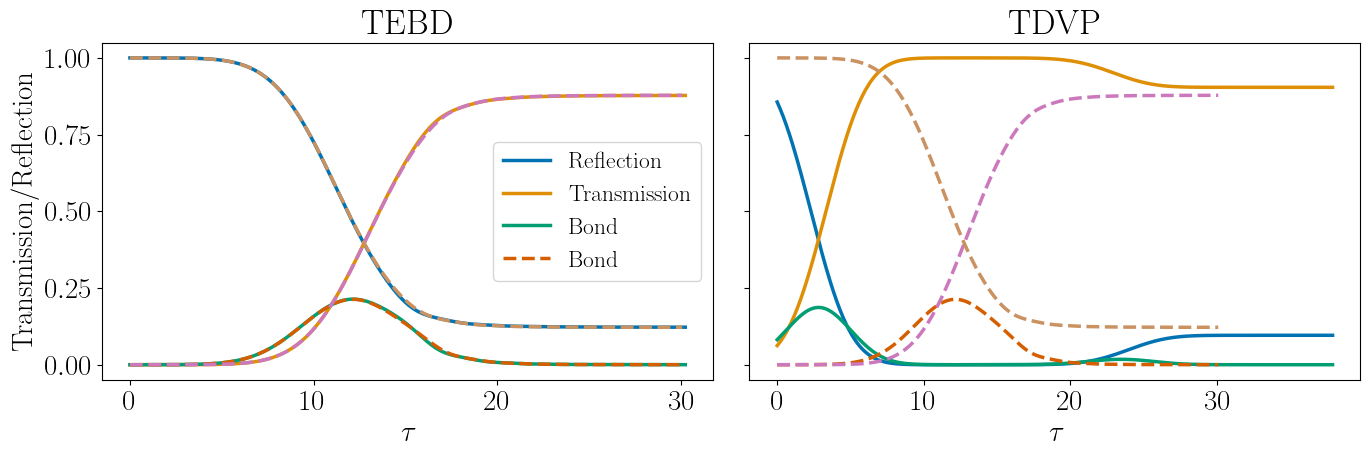

In [72]:
fig, ax = plt.subplots(1,2, figsize=(2*bwidth,bheight), sharey=True)

ax[0].plot(TEBD_times, TEBD_R, linewidth=2.5, label="Reflection")
ax[0].plot(TEBD_times, TEBD_T, linewidth=2.5, label="Transmission")
ax[0].plot(TEBD_times, TEBD_Bond, linewidth=2.5, label="Bond")
ax[0].plot(times, B_new, linewidth=2.5, label="Bond", linestyle="dashed")
ax[0].plot(times, T_new, linewidth=2.5,linestyle="dashed")
ax[0].plot(times, R_new, linewidth=2.5,linestyle="dashed")


ax[0].set_xlabel(r"$\tau$")
ax[0].set_ylabel(r"Transmission/Reflection")
ax[0].set_title("TEBD")
ax[0].legend()

ax[1].plot(TDVP_times, TDVP_R, linewidth=2.5)
ax[1].plot(TDVP_times, TDVP_T, linewidth=2.5)
ax[1].plot(TDVP_times, TDVP_Bond, linewidth=2.5)
ax[1].plot(times, B_new, linewidth=2.5, label="Bond", linestyle="dashed")
ax[1].plot(times, T_new, linewidth=2.5,linestyle="dashed")
ax[1].plot(times, R_new, linewidth=2.5,linestyle="dashed")
ax[1].set_xlabel(r"$\tau$")
ax[1].set_title("TDVP")

plt.tight_layout()

# plt.savefig(fig_route+"transmission_reflection_L={}_spread={}_X0={}.pdf".format(L_, X0, spread))

0.04247534287562996
TEBD final bond dimension: 3
TEBD max bond dimension: 88 found at 0
TDVP final bond dimension: 3
TDVP max bond dimension: 115 found at 0


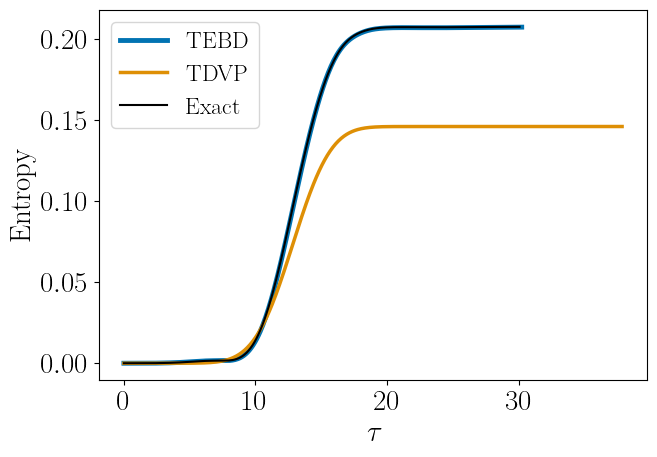

In [73]:
fig, ax = plt.subplots(1,1, figsize=(bwidth,bheight))

plt.plot(TEBD_times, TEBD_entropies/np.log(2), linewidth=3.5, label="TEBD")
plt.plot(TDVP_times, TDVP_entropies/np.log(2),linewidth=2.5,label="TDVP")
plt.plot(times, entropy/np.log(2), c="black", label="Exact")

ax.set_xlabel(r"$\tau$")
ax.set_ylabel(r"Entropy")
ax.legend()

plt.tight_layout()

print(np.max(TEBD_entropies)-np.max(TDVP_entropies))

print("TEBD final bond dimension:", TEBD_bond_dim[-1])
print("TEBD max bond dimension:", np.max(TEBD_bond_dim), "found at",  np.argmax(TEBD_bond_dim))

print("TDVP final bond dimension:", TDVP_bond_dim[-1])
print("TDVP max bond dimension:", np.max(TDVP_bond_dim), "found at",  np.argmax(TDVP_bond_dim))

# plt.savefig(fig_route+"entropy_production_L={}_spread={}_X0={}.pdf".format(L_, X0, spread))

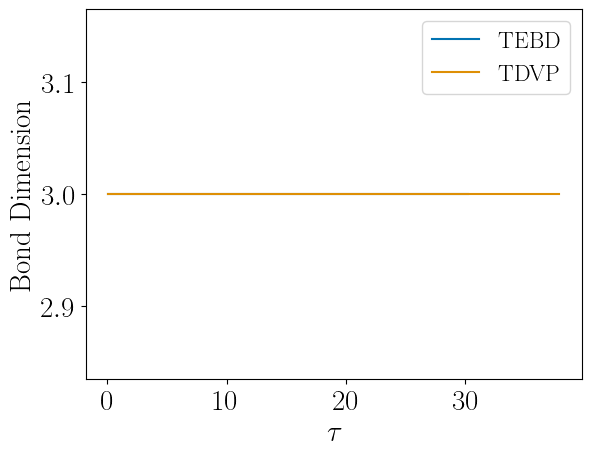

In [74]:
plt.plot(TEBD_times[1:], TEBD_bond_dim[1:], label="TEBD")
plt.plot(TDVP_times[1:], TDVP_bond_dim[1:], label="TDVP")
plt.ylabel(r"Bond Dimension")
plt.xlabel(r"$\tau$")
plt.legend()

**Spread of the wavepacket**

TEBD FWHM:  9.977224729246421
TDVP FWHM:  10.001306025614223


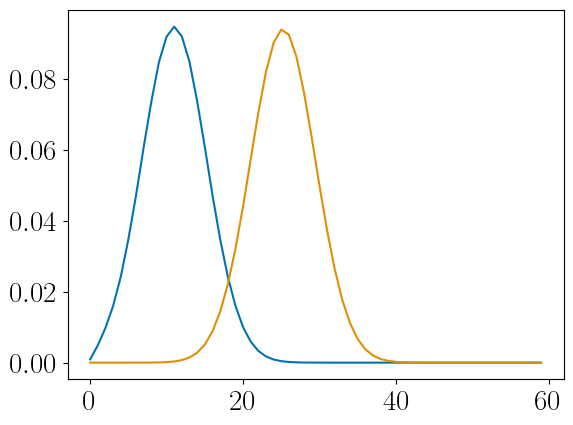

In [75]:
tindex_ = 9
FWHM = get_FWHM(np.arange(0,len(TEBD_occ[tindex_,:L_])) , TEBD_occ[tindex_,:L_], tindex_)
print("TEBD FWHM: ", FWHM)

FWHM = get_FWHM(np.arange(0,len(TDVP_occ[tindex_,:L_])) , TDVP_occ[tindex_,:L_], tindex_)
print("TDVP FWHM: ", FWHM)
plt.plot(TEBD_occ[tindex_,:L_])
plt.plot(TDVP_occ[tindex_,:L_])


**TEBD trajectory**

In [76]:
heat_matrix = TEBD_occ.T
np.shape(heat_matrix)
vg = 2*TEBD_params["J"]*np.sin(TEBD_params["k0"])
xvg = TEBD_params["x0"] + TEBD_times *vg
tau_free = (L_-TEBD_params["x0"])/vg
tau_free


30.283665448744845

estimated time to hit the far wall without coupling:  30.283665448744845


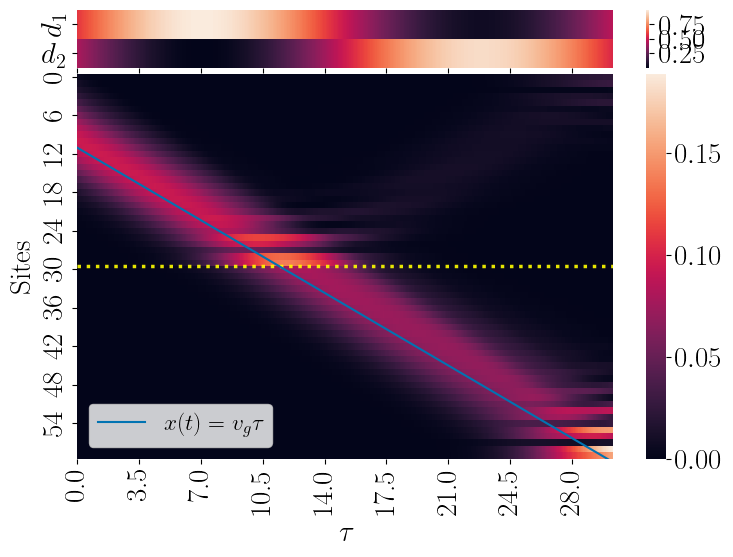

In [77]:
print("estimated time to hit the far wall without coupling: ", tau_free)

fig, ax = plt.subplots(2,1,figsize=(8,6), sharex=True ,gridspec_kw={'height_ratios': [0.15, 1]})

sns.heatmap(heat_matrix[L_:,:],ax=ax[0])
sns.heatmap(heat_matrix[:L_,:],ax=ax[1])

ax[1].set_xlabel(r"$\tau$")
ax[1].set_ylabel("Sites")

ax[1].axhline(TEBD_params["bond_index"], alpha=0.9,linestyle='dotted' ,c="yellow",linewidth=2.5)
ax[1].plot(xvg+0.5, label= r"$x(t)=v_g \tau$")

ax[0].set_yticks([0.5,1.5], [r"$d_1$",r"$d_2$"])
# time ticks
tick_posx = np.arange(0,len(TEBD_times),50)
xtick_label = np.around(tick_posx*(TEBD_params["time_step"]),decimals=1)
ax[1].set_xticks(tick_posx,xtick_label);

plt.legend(loc='lower left')
# reduce vertical
plt.tight_layout(h_pad=0.01)

# plt.savefig(fig_route+"TEBD_trajectory_L={}_spread={}_X0={}.png".format(L_, X0, spread), dpi = 200)

**TDVP trajectory**

In [21]:
heat_matrix = TDVP_occ.T
np.shape(heat_matrix)
vg = 2*TDVP_params["J"]*np.sin(TDVP_params["k0"])
xvg = TDVP_params["x0"] + TDVP_times *vg
tau_free = (L_-TDVP_params["x0"])/vg
tau_free

53.96588698233903

estimated time to hit the far wall without coupling:  53.96588698233903


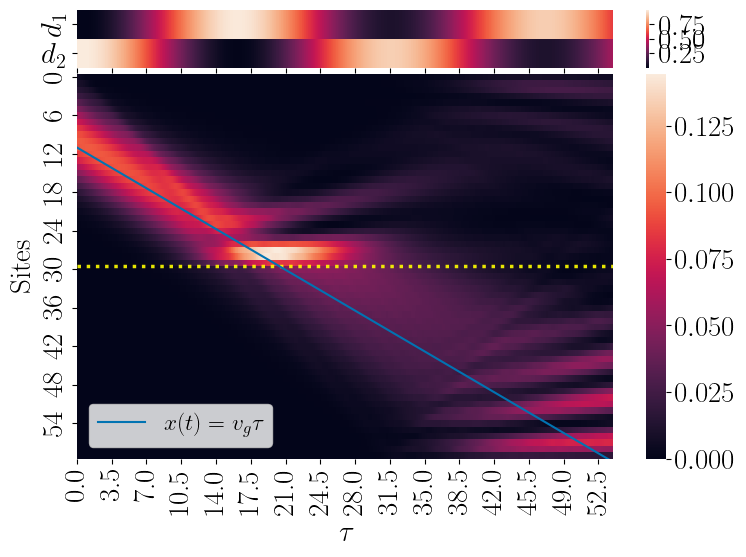

In [22]:
print("estimated time to hit the far wall without coupling: ", tau_free)

fig, ax = plt.subplots(2,1,figsize=(8,6), sharex=True ,gridspec_kw={'height_ratios': [0.15, 1]})

sns.heatmap(heat_matrix[L_:,:],ax=ax[0])
sns.heatmap(heat_matrix[:L_,:],ax=ax[1])

ax[1].set_xlabel(r"$\tau$")
ax[1].set_ylabel("Sites")

ax[1].axhline(TEBD_params["bond_index"], alpha=0.9,linestyle='dotted' ,c="yellow",linewidth=2.5)
ax[1].plot(xvg+0.5, label= r"$x(t)=v_g \tau$")

ax[0].set_yticks([0.5,1.5], [r"$d_1$",r"$d_2$"])
# time ticks
tick_posx = np.arange(0,len(TEBD_times),50)
xtick_label = np.around(tick_posx*(TEBD_params["time_step"]),decimals=1)
ax[1].set_xticks(tick_posx,xtick_label);

plt.legend(loc='lower left')
# reduce vertical
plt.tight_layout(h_pad=0.01)
# plt.savefig(fig_route+"TDVP_trajectory_L={}_spread={}_X0={}.png".format(L_, X0, spread), dpi = 200)